In [1]:
import numpy as np 
import pandas as pd
import sys
import tensorflow as tf
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from transformers import (AutoModelForMaskedLM, AutoTokenizer, BertConfig,
                          BertTokenizer, TFBertModel)
import transformers
from pprint import pprint
import warnings

warnings.filterwarnings('ignore')

max_len=160
num_tags=2

split_df=pd.read_csv('DataSet/QDS-Dataset1_Annotation.csv')

,0
count,4351.000000
mean,108.821191
std,104.763740
min,2.000000
25%,24.000000
50%,79.000000
75%,158.000000
max,976.000000


<AxesSubplot:ylabel='Frequency'>

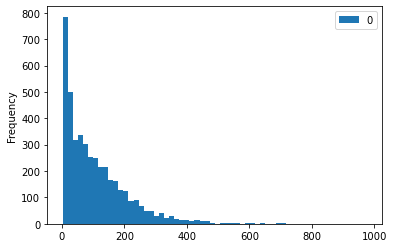

In [2]:
# split by sentence
X=' '.join(split_df['Word'].values)
X=X.split(' . ')

y=' '.join(split_df['label'].values)
y=y.split(' 999 ')
y=[label.split(' ') for label in y]

# print(np.array(X[:3])) # lets take a look at the X 
                       # here i hide the output because the dataset is private

display(pd.DataFrame([len(x) for x in X]).describe())  
pd.DataFrame([len(x) for x in X]).plot(kind='hist',bins=60)

In [3]:
def tokenize_data(data,max_len=64):
    tokenizer = BertTokenizer.from_pretrained("cambridgeltl/BioRedditBERT-uncased")
    encoded = tokenizer.batch_encode_plus(
        data,
        add_special_tokens=True,
        max_length=max_len,
        return_attention_mask=True,
        return_token_type_ids=True,
        pad_to_max_length=True,
        return_tensors="tf",
        truncation=True
    )

    return np.array(encoded["input_ids"], dtype="int32")

# tokenize X
X=tokenize_data(X,max_len=max_len)

# train test split by sentence
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# padding labels
y_train_pad = tf.keras.preprocessing.sequence.pad_sequences(y_train, 
                                                            padding="post",
                                                            maxlen=max_len,
                                                            value=num_tags) # we use a different lable for padding tags
y_test_pad = tf.keras.preprocessing.sequence.pad_sequences(y_test, 
                                                            padding="post",
                                                            maxlen=max_len,
                                                            value=num_tags) # we use a different lable for padding tags

# X_train[:2]

In [4]:
# load bert
def bert(num_tags=2,max_len=64):
    input_ids = tf.keras.layers.Input(shape=(max_len), dtype=tf.int32, name="input_ids")

    embedding = transformers.TFBertModel.from_pretrained("cambridgeltl/BioRedditBERT-uncased")
    embedding.trainable = False    # we dont want to train embedding

    sequence_output = embedding(input_ids)

    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output[0])
    dropout = tf.keras.layers.Dropout(0.3)(bi_lstm)
    output = tf.keras.layers.Dense(num_tags, activation="softmax")(dropout)

    model = tf.keras.models.Model(inputs=[input_ids], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
    )
    return model

model = bert(num_tags+1,max_len) # num of true tag + 1 (padding tag)
model.summary()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Sha

In [5]:
epochs=10
batch_size=128

# we just want to use a small part of the data to test our code
X_train=X_train[:5]
y_train_pad=y_train_pad[:5]

history = model.fit(X_train,
                    y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

Epoch 1/10
1/1 [==============================] - 42s 42s/step - loss: 1.1681
Epoch 2/10
1/1 [==============================] - 10s 10s/step - loss: 0.1588
Epoch 3/10
1/1 [==============================] - 9s 9s/step - loss: 0.0889
Epoch 4/10
1/1 [==============================] - 10s 10s/step - loss: 0.0759
Epoch 5/10
1/1 [==============================] - 11s 11s/step - loss: 0.0622
Epoch 6/10
1/1 [==============================] - 12s 12s/step - loss: 0.0507
Epoch 7/10
1/1 [==============================] - 10s 10s/step - loss: 0.0477
Epoch 8/10
1/1 [==============================] - 12s 12s/step - loss: 0.0476
Epoch 9/10
1/1 [==============================] - 13s 13s/step - loss: 0.0421
Epoch 10/10
1/1 [==============================] - 13s 13s/step - loss: 0.0355


In [7]:
y_pre=model.predict(X_test[:5])
y_pre

array([[[5.1204395e-01, 2.0236671e-02, 4.6771944e-01],
        [5.2603412e-01, 1.8217130e-02, 4.5574871e-01],
        [4.5599598e-01, 1.6974175e-02, 5.2702981e-01],
        ...,
        [8.8739040e-04, 6.7935907e-04, 9.9843329e-01],
        [1.0778067e-03, 8.9960301e-04, 9.9802256e-01],
        [1.9969638e-03, 2.2569208e-03, 9.9574608e-01]],

       [[6.0074025e-01, 3.7279062e-02, 3.6198071e-01],
        [7.8683174e-01, 2.6833449e-02, 1.8633489e-01],
        [5.8251339e-01, 2.0355290e-02, 3.9713123e-01],
        ...,
        [8.8784593e-04, 6.7776430e-04, 9.9843436e-01],
        [1.0796717e-03, 8.9706603e-04, 9.9802327e-01],
        [2.0049000e-03, 2.2584354e-03, 9.9573660e-01]],

       [[6.4482647e-01, 2.2968255e-02, 3.3220536e-01],
        [6.2293416e-01, 1.3461519e-02, 3.6360425e-01],
        [6.6157883e-01, 1.1233499e-02, 3.2718763e-01],
        ...,
        [9.0898294e-04, 6.7134260e-04, 9.9841964e-01],
        [1.1050291e-03, 8.8552956e-04, 9.9800950e-01],
        [2.0515164e-03